**Import libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Transformations**

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize( (0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768) ), # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)), # The mean and std
                                       ])



**Creating test / train split and downloading data**



In [3]:

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 95063190.55it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Data loader arguments and test train data loaders**

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, norm='GN',groupsize=2,drop=0.05):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=54, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,54,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=54, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,16,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,16,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.net_norm(norm,32,groupsize),
            nn.Dropout(drop),
        )

        self.pool2 = nn.AvgPool2d(kernel_size=8)

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.pool1(self.convblock1(x))
        x = self.pool1(self.convblock2(x))
        x = self.pool2(self.convblock3(x))
        x = self.convblock4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def net_norm(self, norm, channels,groupsize=2):
        if norm == 'BN':
            return nn.BatchNorm2d(channels)
        elif norm == 'LN':
            return nn.GroupNorm(1,channels) #(equivalent with LayerNorm)
        elif norm == 'GN':
            return nn.GroupNorm(groupsize,channels) #groups=2

In [6]:
from tqdm import tqdm
import numpy as np

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def print_graph(train_losses,train_acc, test_losses,test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

def show_images(loader):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    dataiter = iter(loader)
    images, labels = next(dataiter)

    num_of_images = 10
    fig = plt.figure(figsize=(10,5))

    for index in range(1, num_of_images+1):
        ax = fig.add_subplot(2, 5, index)
        ax.axis('off')
        actual = classes[labels[index]]
        ax.set_title(f'\n Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(images[index], (1, 2, 0)))

def display_incorrect_images(mismatch, n=20 ):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    display_images = mismatch[:n]
    index = 0
    fig = plt.figure(figsize=(10,5))
    for img in display_images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = classes[img[1]]
        actual = classes[img[2]]
        ax = fig.add_subplot(2, 5, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(image, (1, 2, 0)))
        index = index + 1
    plt.show()

**Model Summary**

In [7]:


#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm='GN').to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 54, 32, 32]          15,552
              ReLU-6           [-1, 54, 32, 32]               0
         GroupNorm-7           [-1, 54, 32, 32]             108
           Dropout-8           [-1, 54, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             540
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1

In [8]:

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [9]:

from torch.optim.lr_scheduler import StepLR

model =  Net(norm='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,train_losses, train_acc)
    #scheduler.step()
    test(model, device, test_loader,test_losses, test_acc)


EPOCH: 1


Loss=1.4964934587478638 Batch_id=390 Accuracy=33.11: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]



Test set: Average loss: 1.5812, Accuracy: 4282/10000 (42.82%)

EPOCH: 2


Loss=1.0676069259643555 Batch_id=390 Accuracy=48.14: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 1.2334, Accuracy: 5560/10000 (55.60%)

EPOCH: 3


Loss=1.3208286762237549 Batch_id=390 Accuracy=55.40: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Average loss: 1.1114, Accuracy: 5973/10000 (59.73%)

EPOCH: 4


Loss=1.01836359500885 Batch_id=390 Accuracy=60.25: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]



Test set: Average loss: 1.0905, Accuracy: 6075/10000 (60.75%)

EPOCH: 5


Loss=0.9905571937561035 Batch_id=390 Accuracy=63.33: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.9650, Accuracy: 6531/10000 (65.31%)

EPOCH: 6


Loss=0.9670413136482239 Batch_id=390 Accuracy=65.09: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 0.8999, Accuracy: 6789/10000 (67.89%)

EPOCH: 7


Loss=0.9218258857727051 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.9054, Accuracy: 6758/10000 (67.58%)

EPOCH: 8


Loss=0.9118233919143677 Batch_id=390 Accuracy=68.29: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.8627, Accuracy: 7009/10000 (70.09%)

EPOCH: 9


Loss=0.8763724565505981 Batch_id=390 Accuracy=69.18: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]



Test set: Average loss: 0.8250, Accuracy: 7091/10000 (70.91%)

EPOCH: 10


Loss=1.0343761444091797 Batch_id=390 Accuracy=70.04: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]



Test set: Average loss: 0.8024, Accuracy: 7201/10000 (72.01%)

EPOCH: 11


Loss=0.7580832839012146 Batch_id=390 Accuracy=71.52: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.7557, Accuracy: 7329/10000 (73.29%)

EPOCH: 12


Loss=0.888809323310852 Batch_id=390 Accuracy=72.25: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.7685, Accuracy: 7359/10000 (73.59%)

EPOCH: 13


Loss=0.8745473027229309 Batch_id=390 Accuracy=72.94: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.7347, Accuracy: 7415/10000 (74.15%)

EPOCH: 14


Loss=0.8287302255630493 Batch_id=390 Accuracy=73.53: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 0.7218, Accuracy: 7467/10000 (74.67%)

EPOCH: 15


Loss=0.9624677896499634 Batch_id=390 Accuracy=74.20: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.7274, Accuracy: 7500/10000 (75.00%)

EPOCH: 16


Loss=0.6700878143310547 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]



Test set: Average loss: 0.6891, Accuracy: 7649/10000 (76.49%)

EPOCH: 17


Loss=0.4964144825935364 Batch_id=390 Accuracy=74.89: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 0.6912, Accuracy: 7546/10000 (75.46%)

EPOCH: 18


Loss=0.5554705858230591 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]



Test set: Average loss: 0.6786, Accuracy: 7635/10000 (76.35%)

EPOCH: 19


Loss=0.7900068163871765 Batch_id=390 Accuracy=75.96: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]



Test set: Average loss: 0.6656, Accuracy: 7728/10000 (77.28%)

EPOCH: 20


Loss=0.6889973878860474 Batch_id=390 Accuracy=76.46: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.6972, Accuracy: 7619/10000 (76.19%)



In [10]:

train_losses1 = [t.cpu().item() for t in train_losses]

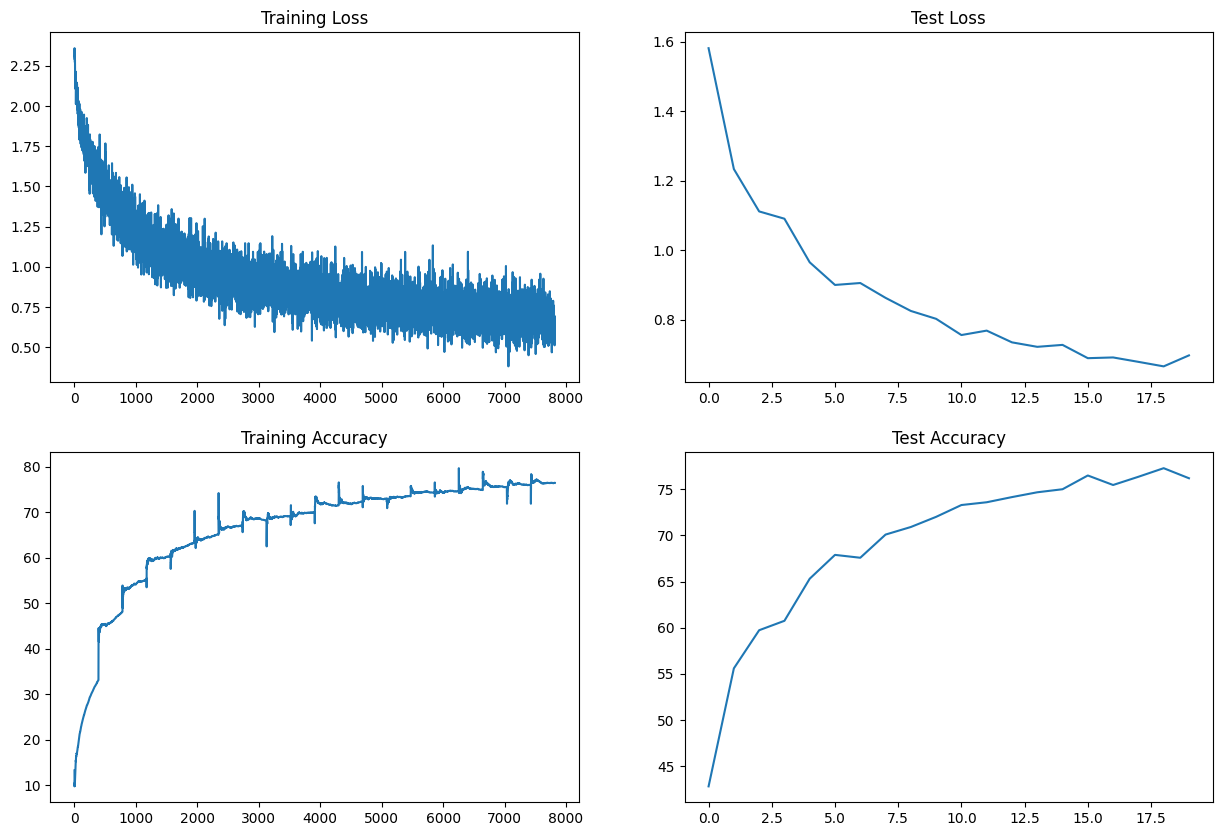

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
print_graph(train_losses1,train_acc, test_losses,test_acc)

In [13]:
wrong_prediction_list = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

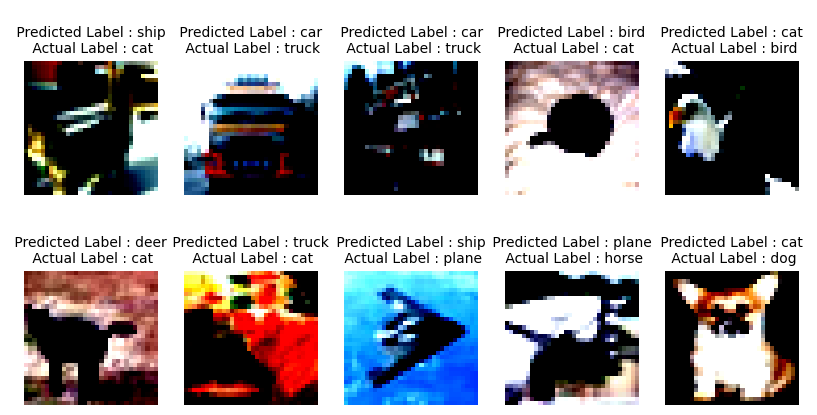

In [14]:

display_incorrect_images(wrong_prediction_list, n=10 )